### This notebook computes the conservatism, i.e. the average overestimation of the systematic errors
### of the ATLAS and CMS results in the SModelS database

In [1]:
# the most important parameters
dictfile = "../../protomodels/historic_database_stats/310.dict"
dropThese = [ "CMS-EXO-20-004", "ATLAS-EXOT-2018-06", "CMS-SUS-20-004", "ATLAS-SUSY-2018-16-hino", "ATLAS-SUSY-2018-16" ]
plot_prefix="/tmp/plots/"
ntoys = 1000 # 25000

In [2]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from functools import reduce
import math

In [3]:
import sys
sys.path.insert(0,"../../protomodels/")
import os

if plot_prefix not in [ "", "./" ] and not os.path.exists ( plot_prefix ):
    os.mkdir ( plot_prefix )

In [4]:
def filterMe ( dataId, values ):
    # we drop the monojets, and the electroweakinos, as they might see new physics
    for dropThis in dropThese:
        if dropThis in dataId:
            return False
    return True

In [5]:
def savefig ( outname : str ):
    # ignore when in jupyter mode, else save figure
    plt.savefig ( f"{plot_prefix}{outname}" )

In [6]:
from multiverse.expResModifier import readDatabaseDictFile
d = readDatabaseDictFile ( dictfile, filterMe )
    
header, data = d["meta"], d["data"]   
#print(header)

In [7]:
f"{len(data)} signal regions will be considered"

'799 signal regions will be considered'

In [8]:
d = {8:{},13:{}}

params = ["origN","expectedBG","bgError","orig_Z","new_Z","newObs"]
for key in data.keys():
    if ":ul:" in key:
        continue
    if "CMS-EXO-20-004" in key: # skip CMS-EXO-20-004
        continue
    labels = [ "CMS", "ATLAS", "SUSY", "SUS", "PAS", "EXOT", "EXO", "CONF" ]
    t = key
    for label in labels:
        t = t.replace( f"{label}-","")
    t = t[:t.find("-")]
    t = int(t) % 2000
    if t < 15: 
        energy = 8
    else: 
        energy = 13
    d[energy][key] = {}
    for i in params:
        d[energy][key][i] = data[key][i]

In [9]:
def calc_p(data,fudge,typ):
    p = {8:{"id":[],"p":[]}, 13:{"id":[],"p":[]}}
    min_events = 3.5
    if typ == "gauss":
        for key in data.keys():
            for anaID in data[key].keys():
                obs = data[key][anaID]["origN"]
                bg = data[key][anaID]["expectedBG"]
                bgerr = fudge*data[key][anaID]["bgError"]
                if bg > min_events:
                    central = bg
                    lmbda = scipy.stats.norm.rvs ( loc=[central]*ntoys, scale=[bgerr]*ntoys )
                    lmbda = lmbda[lmbda>0.]
                    fakeobs = scipy.stats.poisson.rvs ( lmbda )
                    p[key]["id"].append(anaID)
                    #p[key]["p"].append(sum(fakeobs>obs) / len(fakeobs))
                    p[key]["p"].append((sum(fakeobs>obs) + .5*sum(fakeobs==obs)) / len(fakeobs))
                
    if typ == "lognorm":
        for key in data.keys():
            for anaID in data[key].keys():
                obs = data[key][anaID]["origN"]
                bg = data[key][anaID]["expectedBG"]
                bgerr = fudge*data[key][anaID]["bgError"]
                if bg > min_events:
                    central = bg
                    loc = central**2 / np.sqrt ( central**2 + bgerr**2 )
                    stderr = np.sqrt ( np.log ( 1 + bgerr**2 / central**2 ) )
                    lmbda = scipy.stats.lognorm.rvs ( s=[stderr]*ntoys, scale=[loc]*ntoys )
                    fakeobs = scipy.stats.poisson.rvs ( lmbda )
                    p[key]["id"].append(anaID)
                    p[key]["p"].append(sum(fakeobs>obs) / len(fakeobs))
    return p

def calc_T(p,bns):
    n_bns = len(bns) - 1
    pj = 1/n_bns
    size = len(p)
    counts = [0]*n_bns
    for i in p:
        for j in range(n_bns):
            if i>bns[j] and i<bns[j+1]:
                counts[j] += 1
    return sum(((i - size*pj)**2) / (size*pj) for i in counts)

def calc_Tabove(p,bns):
    n_bns = int((len(bns) - 1) / 2)
    pj = 1/n_bns
    p = [i for i in p if i>0.5]
    size = len(p)
    counts = [0]*n_bns
    for i in p:
        for j in range(int((len(bns)-1)/2),int(len(bns)-1)):
            tmp = j - int((len(bns)-1)/2)
            if i>bns[j] and i<bns[j+1]:
                counts[tmp] += 1
    return sum(((i - size*pj)**2) / (size*pj) for i in counts)

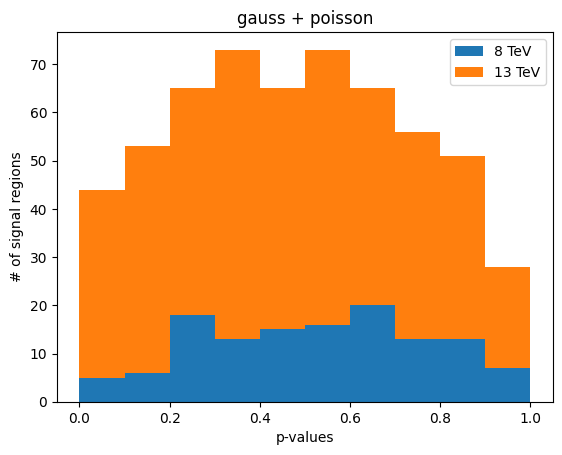

In [10]:
n_bins = 10
bns = np.linspace(0,1,n_bins+1)

p = calc_p(d,fudge=1.,typ="gauss")

plt.hist([p[8]["p"],p[13]["p"]],bins=bns,stacked=True,label=["8 TeV","13 TeV"])
plt.title("gauss + poisson")
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig ( "gauss_poisson.png" )
plt.show()

p_values = p[8]["p"].copy()
p_values.extend(p[13]["p"])

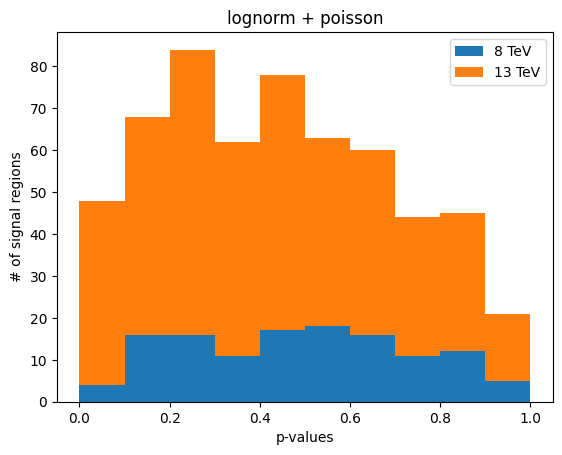

In [11]:
p = calc_p(d,fudge=1.,typ="lognorm")

plt.hist([p[8]["p"],p[13]["p"]],bins=bns,stacked=True,label=["8 TeV","13 TeV"])
plt.title("lognorm + poisson")
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig ( "lognorm_poisson.png" )
plt.show()

p_values = p[8]["p"].copy()
p_values.extend(p[13]["p"])

In [12]:
pfake_gauss = []
n = 25000

for key in d.keys():
    for anaID in d[key].keys():
        newObs = d[key][anaID]["newObs"]
        bg = d[key][anaID]["expectedBG"]
        bgerr = d[key][anaID]["bgError"]
        fakeS = d[key][anaID]["new_Z"]
        if bg > 3.5:
            lmbda = scipy.stats.norm.rvs ( loc=bg, scale=bgerr, size = n )
            lmbda = lmbda[lmbda>0.]
            fakeobs = scipy.stats.poisson.rvs ( lmbda )
            pfake_gauss.append(sum(fakeobs>newObs) / len(fakeobs))
            pfake_gauss.append(scipy.stats.norm.cdf(fakeS))

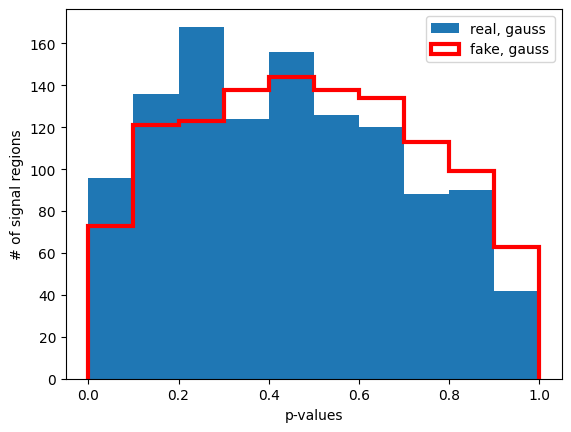

In [13]:
plt.hist(p_values,weights=[2]*len(p_values),bins=bns,label="real, gauss")
plt.hist(pfake_gauss,bins=bns,color="r",histtype="step",lw=3,label="fake, gauss")
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig ( "pvalues.png" )
plt.show()

In [14]:
pfake_lognorm = []
n = 25000

for key in d.keys():
    for anaID in d[key].keys():
        newObs = d[key][anaID]["newObs"]
        bg = d[key][anaID]["expectedBG"]
        bgerr = d[key][anaID]["bgError"]
        fakeS = d[key][anaID]["new_Z"]
        if bg > 3.5:
            central = bg
            loc = central**2 / np.sqrt ( central**2 + bgerr**2 )
            stderr = np.sqrt ( np.log ( 1 + bgerr**2 / central**2 ) )
            lmbda = scipy.stats.lognorm.rvs ( s=stderr, scale=loc, size=n )
            lmbda = lmbda[lmbda>0.]
            fakeobs = scipy.stats.poisson.rvs ( lmbda )
            pfake_lognorm.append(sum(fakeobs>newObs) / len(fakeobs))
            pfake_lognorm.append(scipy.stats.norm.cdf(fakeS))

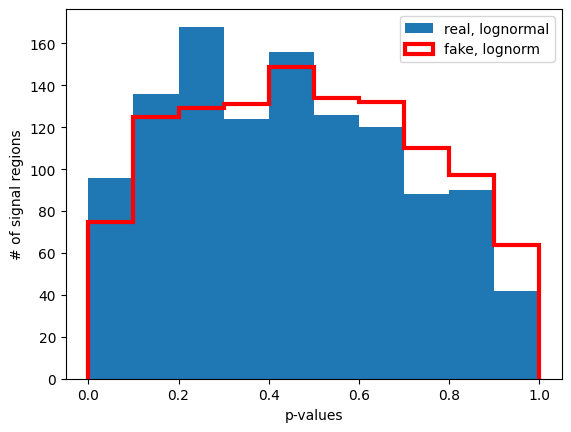

In [15]:
plt.hist(p_values,weights=[2]*len(p_values),bins=bns,label="real, lognormal")
plt.hist(pfake_lognorm,bins=bns,color="r",histtype="step",lw=3,label="fake, lognorm")
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig ( "pvalues_lognorm.png" )
plt.show()

In [16]:
print(scipy.stats.chi2.ppf(0.90,9))
print(scipy.stats.chi2.ppf(0.90,4))

14.683656573259837
7.779440339734858


In [17]:
fudge_lst = np.linspace(0,1,20)

T_all = []
T_8 = []
T_13 = []
for fudge in fudge_lst:
    p = calc_p(d,fudge,typ="gauss")
    p_values = p[8]["p"].copy()
    p_values.extend(p[13]["p"])
    T_all.append(calc_T(p_values,bns))
    T_8.append(calc_T(p[8]["p"],bns))
    T_13.append(calc_T(p[13]["p"],bns))

In [18]:
Tabove_all = []
Tabove_8 = []
Tabove_13 = []
for fudge in fudge_lst:
    p = calc_p(d,fudge,typ="gauss")
    p_values = p[8]["p"].copy()
    p_values.extend(p[13]["p"])
    Tabove_all.append(calc_Tabove(p_values,bns))
    Tabove_8.append(calc_Tabove(p[8]["p"],bns))
    Tabove_13.append(calc_Tabove(p[13]["p"],bns))

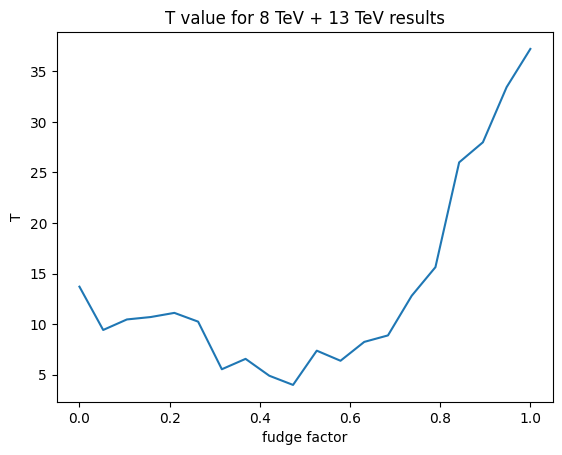

minimum: 3.995 at 0.474


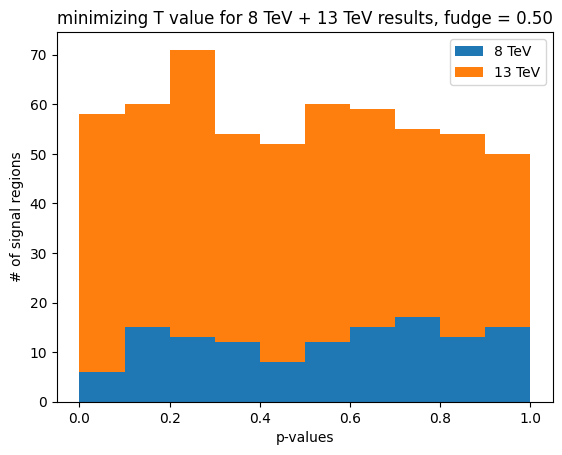

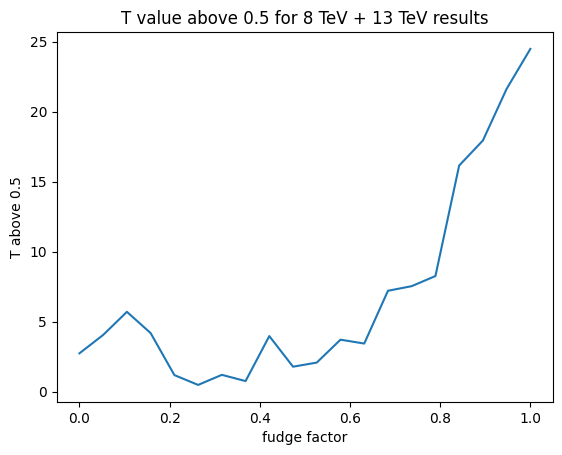

minimum: 0.480 at 0.263


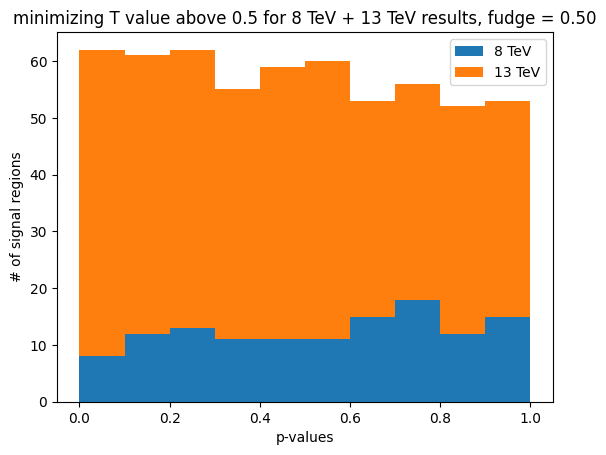

0.47368421052631576


In [19]:
plt.plot(fudge_lst, T_all)
plt.xlabel('fudge factor')
plt.ylabel('T')
plt.title("T value for 8 TeV + 13 TeV results")
savefig ( "T_8_13.png" )
plt.show()
print("minimum: %.3f at %.3f" %(min(T_all), fudge_lst[np.argmin(T_all)]))

fudge = 0.5

p = calc_p(d,fudge,typ="gauss")
p_values = p[8]["p"].copy()
p_values.extend(p[13]["p"])
plt.hist([p[8]["p"],p[13]["p"]],bins=bns,stacked=True,label=["8 TeV", "13 TeV"])
plt.title( f"minimizing T value for 8 TeV + 13 TeV results, fudge = {fudge:.2f}" )
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig ( "pvalues_minT_8_13.png" )
plt.show()

plt.plot(fudge_lst, Tabove_all)
plt.xlabel('fudge factor')
plt.ylabel('T above 0.5')
plt.title("T value above 0.5 for 8 TeV + 13 TeV results")
savefig ( "T_g05_8_13.png" )
plt.show()
print( "minimum: %.3f at %.3f" %(min(Tabove_all), fudge_lst[np.argmin(Tabove_all)]))

fudge = 0.5

p = calc_p(d,fudge,typ="gauss")
p_values = p[8]["p"].copy()
p_values.extend(p[13]["p"])
plt.hist([p[8]["p"],p[13]["p"]],bins=bns,stacked=True,label=["8 TeV", "13 TeV"])
plt.title( f"minimizing T value above 0.5 for 8 TeV + 13 TeV results, fudge = {fudge:.2f}" )
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig ( "pvalues_g05_minT_8_13.png" )
plt.show()

print(fudge_lst[np.argmin(T_all)])

In [20]:
fudge_lst = np.linspace(0,1,50)

T_8 = []
Tabove_8 = []
for fudge in fudge_lst:
    p = calc_p(d,fudge,typ="gauss")
    p_values = p[8]["p"].copy()
    p_values.extend(p[13]["p"])
    T_8.append(calc_T(p[8]["p"],bns))
    Tabove_8.append(calc_Tabove(p[8]["p"],bns))
    
print("Done")

Done


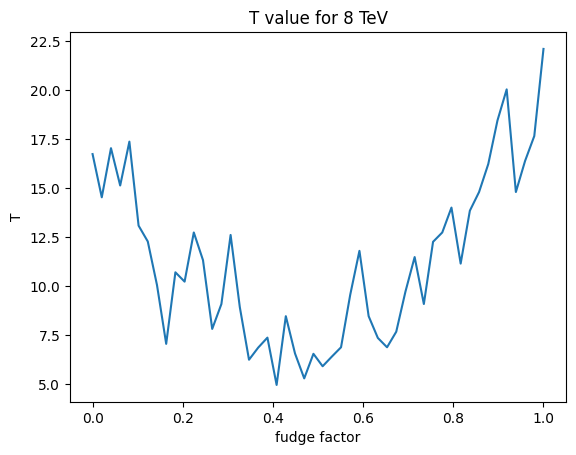

minimum: 4.952 at 0.408


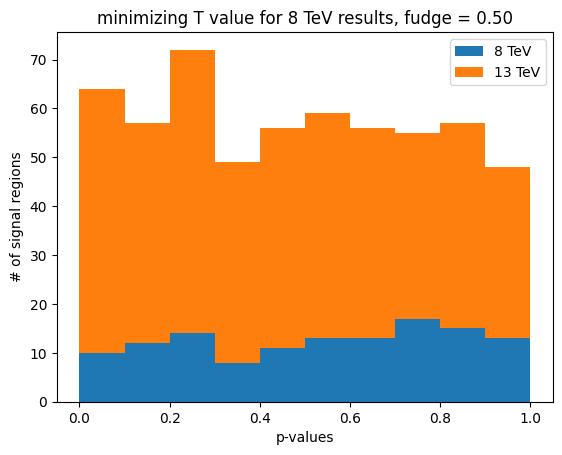

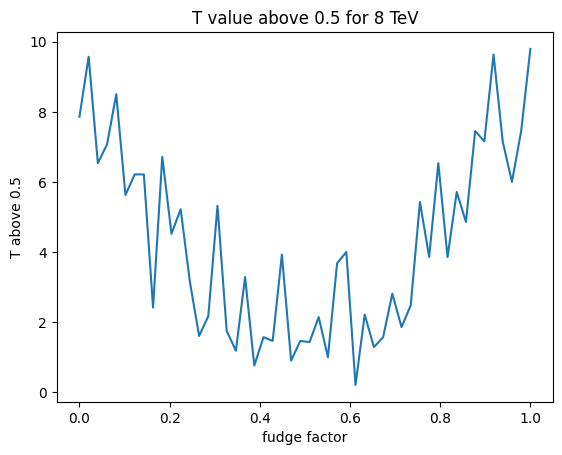

minimum: 0.208 at 0.612


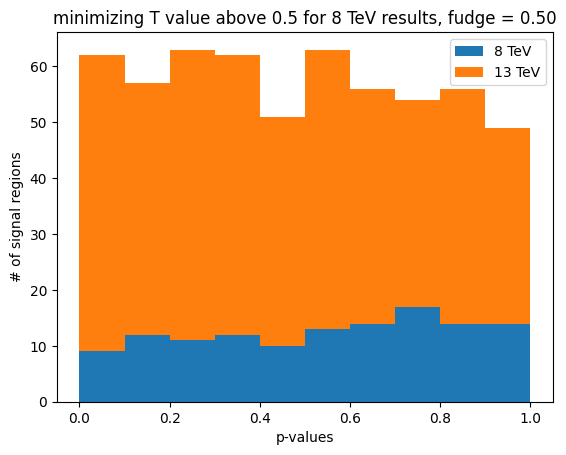

In [21]:
plt.plot(fudge_lst, T_8)
plt.xlabel('fudge factor')
plt.ylabel('T')
plt.title("T value for 8 TeV")
savefig("T_8.png")
plt.show()
print("minimum: %.3f at %.3f" %(min(T_8), fudge_lst[np.argmin(T_8)]))

fudge = 0.5

p = calc_p(d,fudge,typ="gauss")
p_values = p[8]["p"].copy()
p_values.extend(p[13]["p"])
plt.hist([p[8]["p"],p[13]["p"]],bins=bns,stacked=True,label=["8 TeV", "13 TeV"])
plt.title( f"minimizing T value for 8 TeV results, fudge = {fudge:.2f}" )
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig("pvalues_minT_8.png")
plt.show()

plt.plot(fudge_lst, Tabove_8)
plt.xlabel('fudge factor')
plt.ylabel('T above 0.5')
plt.title("T value above 0.5 for 8 TeV")
savefig("T_gt05_8.png")
plt.show()
print("minimum: %.3f at %.3f" %(min(Tabove_8), fudge_lst[np.argmin(Tabove_8)]))

fudge = 0.5

p = calc_p(d,fudge,typ="gauss")
p_values = p[8]["p"].copy()
p_values.extend(p[13]["p"])
plt.hist([p[8]["p"],p[13]["p"]],bins=bns,stacked=True,label=["8 TeV", "13 TeV"])
plt.title( f"minimizing T value above 0.5 for 8 TeV results, fudge = {fudge:.2f}" )
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
savefig("pvalues_minT_gt05_8.png")
plt.legend()
plt.show()

In [22]:
fudge_lst = np.linspace(0,1,50)

T_13 = []
Tabove_13 = []
for fudge in fudge_lst:
    p = calc_p(d,fudge,typ="gauss")
    p_values = p[8]["p"].copy()
    p_values.extend(p[13]["p"])
    T_13.append(calc_T(p[8]["p"],bns))
    Tabove_13.append(calc_Tabove(p[8]["p"],bns))
    
print("Done")

Done


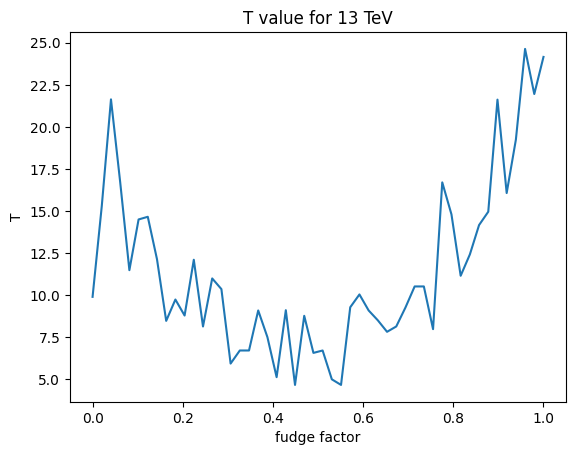

minimum: 4.651 at 0.449


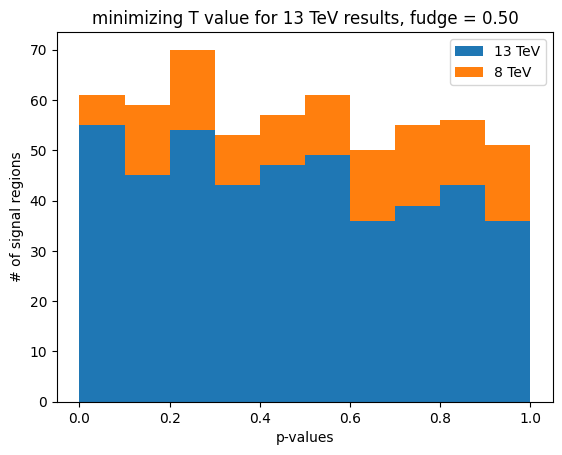

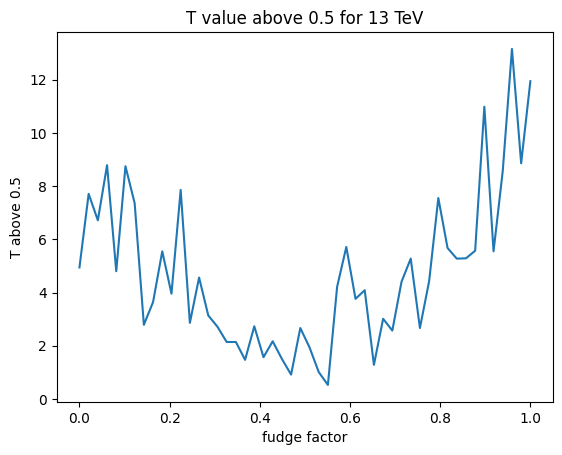

minimum: 0.529 at 0.551


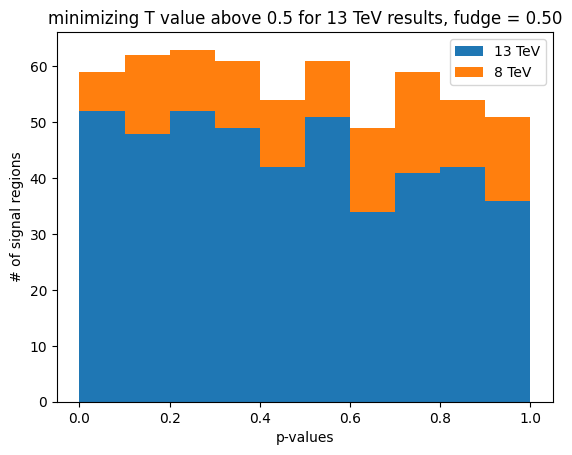

In [23]:
plt.plot(fudge_lst, T_13)
plt.xlabel('fudge factor')
plt.ylabel('T')
plt.title("T value for 13 TeV")
savefig("T_13.png")
plt.show()
print("minimum: %.3f at %.3f" %(min(T_13), fudge_lst[np.argmin(T_13)]))

fudge = 0.5

p = calc_p(d,fudge,typ="gauss")
p_values = p[8]["p"].copy()
p_values.extend(p[13]["p"])
plt.hist([p[13]["p"],p[8]["p"]],bins=bns,stacked=True,label=["13 TeV", "8 TeV"])
plt.title( f"minimizing T value for 13 TeV results, fudge = {fudge:.2f}" )
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig("pvalues_13.png")
plt.show()

plt.plot(fudge_lst, Tabove_13)
plt.xlabel('fudge factor')
plt.ylabel('T above 0.5')
plt.title("T value above 0.5 for 13 TeV")
savefig("T_gt05_13.png")
plt.show()
print("minimum: %.3f at %.3f" %(min(Tabove_13), fudge_lst[np.argmin(Tabove_13)]))

fudge = 0.5

p = calc_p(d,fudge,typ="gauss")
p_values = p[8]["p"].copy()
p_values.extend(p[13]["p"])
plt.hist([p[13]["p"],p[8]["p"]],bins=bns,stacked=True,label=["13 TeV", "8 TeV"])
plt.title( f"minimizing T value above 0.5 for 13 TeV results, fudge = {fudge:.2f}" )
plt.xlabel('p-values')
plt.ylabel('# of signal regions')
plt.legend()
savefig("pvalues_gt05_13.png")
plt.show()

In [24]:
p = calc_p(d,fudge=1.,typ="gauss")

p_lst = p[8]["p"].copy()
p_lst.extend(p[13]["p"])
id_lst = p[8]["id"].copy()
id_lst.extend(p[13]["id"])

p_sort, id_sort = zip(*sorted(zip(p_lst,id_lst)))

In [25]:
print("lowest:\n")
print(tabulate(list(zip(id_sort[:10],p_sort[:10])),headers=["AnaID", "p value"], tablefmt='orgtbl'))
    
print("\nhighest:\n")
print(tabulate(list(zip(id_sort[-10:],p_sort[-10:])),headers=["AnaID", "p value"], tablefmt='orgtbl'))

lowest:

| AnaID                                        |   p value |
|----------------------------------------------+-----------|
| ATLAS-SUSY-2017-03:SR3l_ISR                  |    0.001  |
| ATLAS-SUSY-2019-09:SRlow_0Jd                 |    0.004  |
| CMS-PAS-SUS-16-052-agg:ar3                   |    0.004  |
| ATLAS-SUSY-2017-03:SR3l_Low                  |    0.0055 |
| ATLAS-SUSY-2015-02:SR1                       |    0.0085 |
| CMS-PAS-SUS-16-052-agg:ar1                   |    0.0175 |
| ATLAS-SUSY-2016-07:2j_Meff_1200              |    0.0195 |
| ATLAS-SUSY-2018-32:SRSF_1c_cuts              |    0.021  |
| ATLAS-SUSY-2018-22-multibin:MB-GGd-4-2200-10 |    0.0225 |
| ATLAS-SUSY-2018-12:SRBTT                     |    0.026  |

highest:

| AnaID                                  |   p value |
|----------------------------------------+-----------|
| CMS-SUS-21-002:W_SR5                   |  0.9535   |
| ATLAS-SUSY-2018-10:6j1b_3              |  0.954    |
| CMS-SUS-16-050-agg:ar15   

In [26]:
atlas_count = 0
cms_count = 0
em_count = 0
ul_count = 0

for key in data.keys():
    if "ATLAS" in key:
        atlas_count += 1
    if "CMS" in key:
        cms_count += 1
    if ":ul:" not in key:
        em_count += 1
    if ":ul:" in key:
        ul_count += 1
        
print( f"{atlas_count} ATLAS, {cms_count} CMS, {em_count} EMs, {ul_count} ULs" )

529 ATLAS, 270 CMS, 799 EMs, 0 ULs
